In [2]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import tempfile
import os


class CEnv:
    def __init__(self):
        self.executable = None

    def compile(self, code: str) -> str:
        with tempfile.NamedTemporaryFile(mode="w", suffix=".c", delete=False) as temp_c:
            temp_c.write(code)
            c_file = temp_c.name

        try:
            executable = c_file[:-2]
            subprocess.run(
                ["gcc", c_file, "-O3", "-o", executable],
                capture_output=True,
                text=True,
                check=True,
            )
            self.executable = executable
            return executable

        except subprocess.CalledProcessError as e:
            raise Exception(f"Compilation Error: {e.stderr}")
        finally:
            os.unlink(c_file)

    def run(self, code: str) -> tuple[str, str]:
        try:
            executable = self.compile(code)
            result = subprocess.run([executable], capture_output=True, text=True)
            return result.stdout, result.stderr

        finally:
            if self.executable:
                try:
                    os.unlink(self.executable)
                except OSError:
                    pass

2**12 = 4.0 KB
2**13 = 8.0 KB
2**14 = 16.0 KB
2**15 = 32.0 KB
2**16 = 64.0 KB
2**17 = 128.0 KB
2**18 = 256.0 KB
2**19 = 512.0 KB
2**20 = 1.0 MB
2**21 = 2.0 MB
2**22 = 4.0 MB
2**23 = 8.0 MB


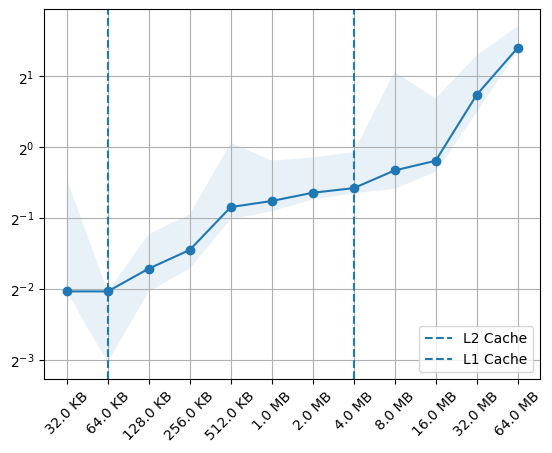

In [4]:
def size_to_str(n):
    if n < 1024:
        return f"{n} B"
    elif n < 1024 * 1024:
        return f"{n / 1024} KB"
    else:
        return f"{n / 1024 / 1024} MB"


def bench(c_env, n, M):
    stdout, stderr = c_env.run(
        f"""
    #include <stdio.h>
    #include <stdlib.h>
    #include <time.h>

    void cache_test(int32_t* a, int32_t* idx) {{
        int32_t sum = 0;
        for (int32_t i = 0; i < {n}; i++) {{
            sum += a[idx[i]];
        }}
        if (sum == -12345) printf("DONT OPT ME", sum);
    }}

    int main(int argc, char **argv) {{
        static int32_t a[{n}];
        static int32_t idx[{n}];

        struct timespec start, end;
        double duration_ns;
        
        for (int j = 0; j < {M}; j++) {{
            for (int32_t i = 0; i < {n}; i++) {{
                a[i] = i;
                idx[i] = i;
            }}
            for (int32_t i = {n}-1; i > 0; i--) {{
                int32_t j = rand() % (i + 1);
                int32_t temp = idx[i];
                idx[i] = idx[j];
                idx[j] = temp;
            }}
            
            clock_gettime(CLOCK_MONOTONIC, &start);
            cache_test(a, idx);
            clock_gettime(CLOCK_MONOTONIC, &end);
            duration_ns = (end.tv_sec - start.tv_sec) * 1e9 + (end.tv_nsec - start.tv_nsec);


            printf("%.0f ", duration_ns);
        }}
        return 0;
    }}
    """
    )
    return np.array(stdout.strip().split(" ")).astype(float)


M = 100
log_ns = np.arange(12, 24)
ns = 2**log_ns
working_sets = 8 * ns  # 2 arrays of n elements of 4 bytes each
times = np.zeros((len(log_ns), M))

c_env = CEnv()

for i, logn in enumerate(log_ns):
    n = 2**logn
    print(f"2**{logn} = {size_to_str(n)}")
    times[i] = bench(c_env, n, M)

plt.loglog(base=2)
plt.grid()
plt.plot(working_sets, np.median(times, axis=1) / ns, "-o")
plt.axvline(2**22, linestyle="--", label=f"L2 Cache")
plt.axvline(2**16, linestyle="--", label=f"L1 Cache")
plt.fill_between(
    working_sets,
    np.quantile(times, 0.025, axis=1) / ns,
    np.quantile(times, 0.975, axis=1) / ns,
    alpha=0.1,
)
plt.xticks(working_sets, [size_to_str(ws) for ws in working_sets], rotation=45)
plt.legend()

In [141]:
def print_results_table(ns, times):
    print("Size\t\tMedian(ns/n)\tStd(ns/n)\tWorking Set")
    print("-" * 60)
    for i, n in enumerate(ns):
        time_per_n = times[i] / n
        median = np.median(time_per_n)
        std = np.std(time_per_n)
        # Total working set is 8n bytes (2 arrays * 4 bytes per int32)
        working_set = size_to_str(8 * n)
        print(f"2^{int(np.log2(n))}\t\t{median:.2f}\t\t{std:.2f}\t\t{working_set}")


print_results_table(ns, times)

Size		Median(ns/n)	Std(ns/n)	Working Set
------------------------------------------------------------
2^12		0.49		0.10		32.0 KB
2^13		0.24		0.15		64.0 KB
2^14		0.37		0.08		128.0 KB
2^15		0.49		0.10		256.0 KB
2^16		0.47		0.11		512.0 KB
2^17		0.57		0.15		1.0 MB
2^18		0.62		0.23		2.0 MB
2^19		0.64		0.10		4.0 MB
2^20		0.70		0.10		8.0 MB
2^21		0.91		1.31		16.0 MB
2^22		1.54		0.18		32.0 MB
2^23		2.76		0.37		64.0 MB
